In [2]:
# !jupyter nbconvert --no-prompt --to=script deconv_example_manga.ipynb 

[NbConvertApp] Converting notebook deconv_example_manga.ipynb to script
[NbConvertApp] Writing 19128 bytes to deconv_example_manga.py


# Example: Deconvolve SDSS-IV MaNGA data and compare the difference in kinematcis

Author: Haeun Chung (University of Arizona, haeunchung@email.arizona.edu)


This example deconvolve one of the [SDSS-IV MaNGA](https://www.sdss.org/surveys/manga/) and compare the 2D line-of-sight velocity distribution difference measured from the original MaNGA data and the deconvolved MaNGA data.
Specifically, this example reproduces the figure ?? of Chung et. al. 2020 for the MaNGA data ????-?????.

## Required packages
* NUMPY: > v1.15
* SCIPY: > v1.1.0
* ASTROPY: > v3.0.4

(may work with lower version as well)    
This code was tested in both Linux/MacOS and Windows
    
**pPXF needs to be downloaded and installed separately from https://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf**

In [2]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, system
from astropy.io import fits
from time import perf_counter
import urllib.request

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
from deconv import cube_deconv
from ppxf_wrap import ppxf_wrap

import warnings

if True:
    print('Set warnings.filterwarnings as "ignore"')
    print('Warning Message will not be printed')
    warnings.filterwarnings("ignore")


---
## Download MaNGA Data & Catalog
Download MaNGA cube data and catalog from SDSS-IV DR16 Science Archieve Server (https://data.sdss.org/sas/dr16/)

* MaNGA galaxy used in this example: 8313-12705 <https://dr16.sdss.org/marvin/galaxy/8313-12705/>
* MaNGA data access <https://www.sdss.org/dr16/manga/manga-data/data-access/>
* MaNGA catalog <https://www.sdss.org/dr16/manga/manga-data/catalogs/>
    * datamodel: <https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/drpall.html>


Start downloading manga-8313-12705-LOGCUBE.fits.gz from SDSS server. This may take several minutes.
The file is being download from here:  https://data.sdss.org/sas/dr16/manga/spectro/redux/v2_4_3/8313/stack/manga-8313-12705-LOGCUBE.fits.gz
Start download
Downloaded complete
Start downloading drpall-v2_4_3.fits from SDSS server. This may take several seconds.
The file is being download from here:  https://data.sdss.org/sas/dr16/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits
Start download
Downloaded complete
Start downloading 8313-12705.png from SDSS server. This may take several seconds.
The file is being download from here:  https://data.sdss.org/sas/dr16/manga/spectro/redux/v2_4_3/8313/stack//images/12705.png
Start download
Downloaded complete


Text(0.5, 1.0, '8313-12705')

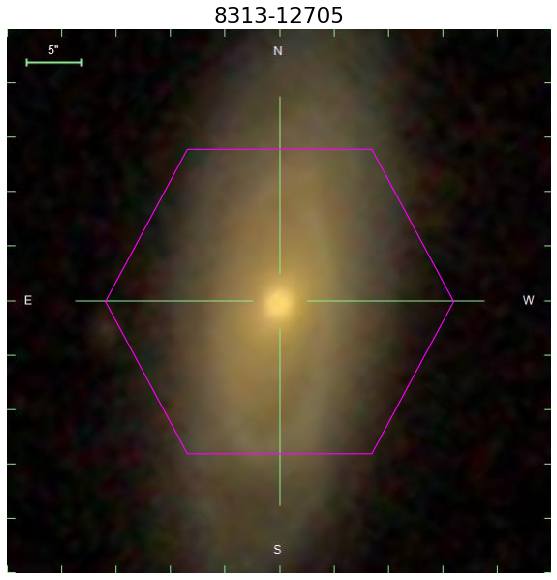

In [3]:
plate=8313
ifudsgn=12705
plateifu=str(plate)+'-'+str(ifudsgn)
ori_file_type='LOGCUBE'
deconv_file_type='LOGDCCUBE'
ori_file_ext='.fits.gz'
deconv_file_ext='.fits'
save_plot=True

ori_manga_file='-'.join(['manga',str(plate),str(ifudsgn),ori_file_type])+ori_file_ext
deconv_manga_file='-'.join(['manga',str(plate),str(ifudsgn),deconv_file_type])+deconv_file_ext

#current directory
cdir='./'

sas_ver='dr16'
manga_ver='v2_4_3'

#search file
if not path.exists(cdir+ori_manga_file):

    sas_url="https://data.sdss.org/sas/"+sas_ver+"/manga/spectro/redux/"+manga_ver+"/"+str(plate)+'/stack/'
    
    print("Start download "+ori_manga_file+" from SDSS server. This may take several minutes.")
    print("The file is being downloaded from here: ",sas_url+ori_manga_file)
    print('Start download')
    urllib.request.urlretrieve(sas_url+ori_manga_file, cdir+ori_manga_file)
    print('Download completed')



# MaNGA Catalog file (DR16)
drpall_file='drpall-'+manga_ver+'.fits'

# download drpall file if not exist.
if not path.exists(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/"+sas_ver+"/manga/spectro/redux/"+manga_ver+"/"
    print("Start download "+drpall_file+" from SDSS server. This may take several seconds.")
    print("The file is being downloaded from here: ",sas_url+drpall_file)
    print('Start download')
    urllib.request.urlretrieve(sas_url+drpall_file, cdir+drpall_file)    
    print('Download completed')
    
image_file=plateifu+'.png'
if not path.exists(cdir+image_file):
    sas_url="https://data.sdss.org/sas/"+sas_ver+"/manga/spectro/redux/"+manga_ver+"/"+str(plate)+'/stack/'
    print("Start download "+image_file+" from SDSS server. This may take several seconds.")
    print("The file is being downloaded from here: ",sas_url+'/images/'+str(ifudsgn)+'.png')
    print('Start download')
    urllib.request.urlretrieve(sas_url+'/images/'+str(ifudsgn)+'.png', cdir+image_file)
    print('Download completed')
    
# Show MaNGA galaxy image
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plt.rcParams.update({'font.family':'sans-serif','font.size': 18})
ax.imshow(matplotlib.image.imread(cdir+image_file),aspect='equal')
ax.axis('off')
ax.set_title(plateifu)


---
## Read galaxy information and cube data 

Data units to be read: 'FLUX', 'IVAR', 'MASK', 'WAVE', 'SPECRES'

Headers to be read: 'Primary', 'FLUX'

parameters to be read from drpall: redshift


In [4]:
class read_cube():
    def __init__(self, plate, ifudsgn, redshift, file_path):
        self.plate=plate
        self.ifudsgn=ifudsgn
        self.plateifu=str(plate)+'-'+str(ifudsgn)
        self.redshift=redshift
        
        print('start read ',file_path)        
        cube = fits.open(file_path)
        self.flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
        self.ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
        self.mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
        self.wave = cube['WAVE'].data
        self.specres = cube['SPECRES'].data
        self.pri_hdr = cube[0].header
        self.flux_hdr=cube['FLUX'].header   
        print('end read ',file_path)      


In [5]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
redshift=tbdata['nsa_z'][idx][0]
file_path=cdir+ori_manga_file

cube=read_cube(plate, ifudsgn, redshift, file_path)
print("MaNGA Galaxy: ",cube.plateifu)
print("Redshift: ",cube.redshift)

start read  ./manga-8313-12705-LOGCUBE.fits.gz
end read  ./manga-8313-12705-LOGCUBE.fits.gz
MaNGA Galaxy:  8313-12705
Redshift:  0.0315371


## Auxilary Routine 1: Plot galaxy spectrum

* Plot galaxy spectrum at particular spaxel.

Save spectrum plot into  8313-12705_spectrum_37_37.png
Cube 2D size:  74 by 74


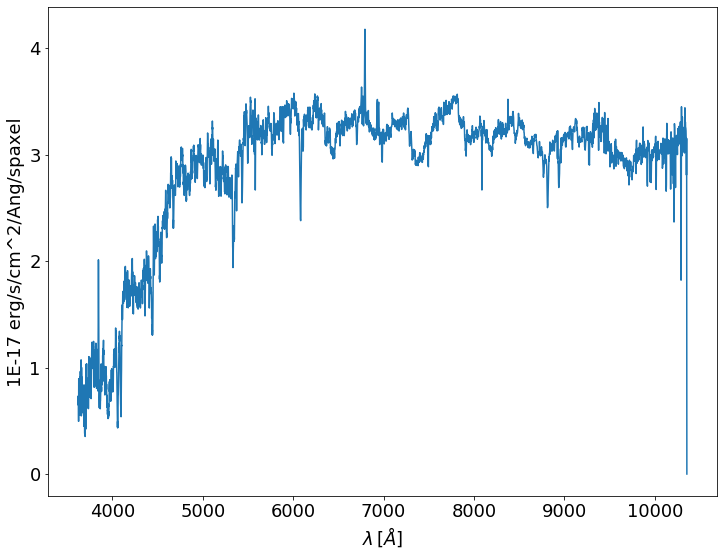

In [6]:
def plot_galaxy_spectrum(px, py, flux, wave, flux_hdr, 
                         save_plot=False, save_name='spectrum.png'):
    fig=plt.figure(figsize=(12,9))
    ax=fig.add_subplot(111)
    ax.plot(wave, flux[px, py])
    ax.set_xlabel(r'$\lambda \, [\AA]$')
    ax.set_ylabel(flux_hdr['BUNIT'])
    if save_plot:
        fig.savefig(save_name,dpi=128, bbox_inches='tight')
        print('Save spectrum plot into ',save_name)

    
x_center = np.int(cube.flux_hdr['CRPIX1']) - 1
y_center = np.int(cube.flux_hdr['CRPIX2']) - 1

save_name=cube.plateifu+'_spectrum_'+str(x_center)+'_'+str(y_center)+'.png'
plot_galaxy_spectrum(x_center, y_center, cube.flux, cube.wave, cube.flux_hdr, 
                     save_plot=save_plot, save_name=save_name)
print('Cube 2D size: ', cube.flux.shape[0], 'by', cube.flux.shape[1])

## Auxilary Routine 2: Plot galaxy flux map

* plot 2D flux map at particular wavelength bin or range 

Save 2dflux plot into  8313-12705_2dflux.png


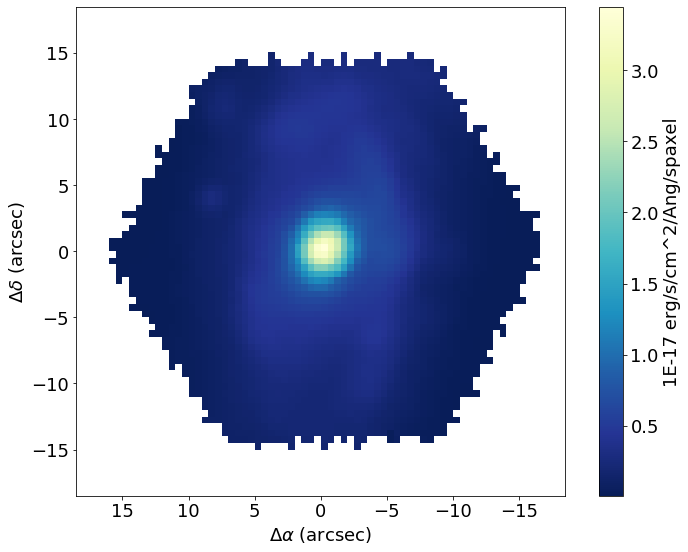

In [7]:
def plot_galaxy_2dflux(flux, mask, flux_hdr, wave_mask, wavebin_widths, 
                       save_plot=False, save_name='2dflux.png'):
    do_not_use = (mask & 2**10) > 0
    flux_m = np.ma.array(flux, mask=do_not_use)
    flux_p = (flux_m[:, :, wave_mask]*wavebin_widths).sum(axis=2)/np.sum(wavebin_widths) 
    im = flux_p.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
    dx = flux_hdr['CD1_1'] * 3600.  # deg to arcsec
    dy = flux_hdr['CD2_2'] * 3600.  # deg to arcsec
    x_center = np.int(flux_hdr['CRPIX1']) - 1
    y_center = np.int(flux_hdr['CRPIX2']) - 1
    x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx
    y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
    extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]
    
    fig=plt.figure(figsize=(12,9))
    ax=fig.add_subplot(111)
    img=ax.imshow(im, extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
    plt.colorbar(img, label=flux_hdr['BUNIT'])
    ax.set_xlabel(r'$\Delta \alpha $ (arcsec)')
    ax.set_ylabel(r'$\Delta \delta $ (arcsec)')
    if save_plot:
        fig.savefig(save_name,dpi=128, bbox_inches='tight')
        print('Save 2dflux plot into ',save_name)
    

wave_center=6563*(1+cube.redshift)
wave_width=10
wave_mask=np.nonzero((cube.wave > wave_center-wave_width/2) 
                     & (cube.wave < wave_center+wave_width/2))[0]
wavebin_widths=cube.wave[wave_mask+1]-cube.wave[wave_mask]
save_name=plateifu+'_2dflux.png'
plot_galaxy_2dflux(cube.flux, cube.mask, cube.flux_hdr, wave_mask, 
                   wavebin_widths, save_plot=save_plot, save_name=save_name)

## Deconvolve MaNGA data cube

Finally, time to deconvolve cube data
* Deconvolve MaNGA data and save the result in FITS format.
* Number of deconvolution iteration: 20
* Result file name format: manga-{plate}-{ifudsgn}-LOGDCCUBE.fits.gz

In [8]:
#retruns psf function obtained by fitting linear function to the PSF FWHM at four bands.
def return_psf_fwhm_func(pri_hdr, nterms=1):
    psf_waves=np.array([4770, 6231, 7625, 9134])  #griz #u=3543
    psf_str=['GFWHM','RFWHM','IFWHM','ZFWHM']
    npsf=len(psf_str)
    fwhm_arr=np.zeros(npsf)
    for i in range(npsf): 
        fwhm_arr[i]=pri_hdr[psf_str[i]]
    coeff=np.polyfit(psf_waves, fwhm_arr, nterms)
    return lambda x: coeff[0]*x+coeff[1]

def run_deconv(flux, ivar, mask, wave, specres, pri_hdr, flux_hdr, outname):
    dx=flux_hdr['CD1_1'] * 3600.
    dy=flux_hdr['CD2_2'] * 3600.
    manga_pixelscale=dx

    input_flux=flux.astype('float64')
    input_wave=wave.astype('float64')

    psf_nterms=1    
    psf_fwhm_func=return_psf_fwhm_func(pri_hdr, nterms=psf_nterms)
    mask_simple=((mask & 1) ==0)


    niter=20 #number of deconvolution iteration=20
    dcflux, dcmask_simple=cube_deconv(input_flux, input_wave, mask_simple, psf_fwhm_func,
                               pixelscale=manga_pixelscale, niter=niter)

    dcmask=mask | (dcmask_simple | 1024)

    extname_arr=np.array([
    'PRIMARY', 
    'FLUX',
    'IVAR',
    'MASK', 
    'WAVE',
    'SPECRES'
    ])


    hdu = fits.PrimaryHDU()
    hdu.writeto(outname, overwrite=True)

    fits.writeto(outname, hdu.data, pri_hdr, overwrite=True)
    fits.append(outname, np.transpose(dcflux, axes=(2,1,0)))
    fits.append(outname, np.transpose(ivar, axes=(2,1,0)))
    fits.append(outname, np.transpose(mask, axes=(2,1,0)))
    fits.append(outname, wave)
    fits.append(outname, specres)

    append_file=fits.open(outname, mode='update')

    for h in range(len(extname_arr)):
        hdr=append_file[h].header
        hdr['EXTNAME']=extname_arr[h]

    hdr=append_file[0].header
    hdr['NITER']=niter
    hdr_flux=append_file['FLUX'].header
    hdr_flux['CD1_1']=dx/3600
    hdr_flux['CD2_2']=dy/3600

    append_file.close()

#     system('gzip -f '+outname)
#     print('gzip -f '+outname)

In [9]:
outname=cdir+deconv_manga_file
run_deconv(cube.flux, cube.ivar, cube.mask, cube.wave, cube.specres, 
           cube.pri_hdr, cube.flux_hdr, outname)

/home/hchung/deconv/deconv.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  phi = (ifft2(fft2(psi)*fpsf)).astype('float64')
/home/hchung/deconv/deconv.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  psi=psi*((ifft2(fft2(div)*fpsf)).astype('float64'))


remaining time to finish deconvolution (approx.): 48 sec
deconvolution finished
total time: 48 sec


## Measure 2D line-of-sight distribution from both original and deconvolved MaNGA data
* Use Penalized Pixel-Fitting method (pPXF) developed by Michele Cappellari to extract stellar kinematics of galaxy. 
* http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf
* pPXF must be installed separately.
* pPXF fits template spectrum to the given galaxy spectrum to fit the galaxy kinematics.
* In this example, we use only two galaxy templates from MILES library supplied along with pPXF distribution, just to maximize the fitting speed (It is pretty accurate).
    * Base MILES models, Vazdekis et al. (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    * Unimodel Initial Mass Funcsion (logarithmic slope = 1.3)
    * Metalicity (log(Z/Z_solar)=0)
    * Age: 1 Gyr, 2 Gyr, 8 Gyr, and 10 Gyr
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe.fits
    * Template spectrum resolution: 2.51 Angstrom
    * Template are linearly binned.
    * Those files are identical to the template files supplied along with pPXF.
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * supplied along with the pPXF distribution ($pPXF_dir/miles_models)
* Full base MILES models can be downloaded from below link
    * http://research.iac.es/proyecto/miles/pages/spectral-energy-distributions-seds/miles.php

* The warpper of pPXF is written separatly in ppxf_wrap.py.
* ppxf_wrap.py is modified from one of the pPXF examples (ppxf_example_kinematics_sdss.py), written by Michele Cappellari

### Measure line of sight velocity using ppxf_wrap
* ppxf_wrap measures velocity at each spaxel, one by one.
* Result will be saved in FITS format.
* Result file name format: manga-{plate}-{ifudsgn}-LOG{CUBE}_2DLOS.fits

In [10]:
def run_ppxf(flux, ivar, mask, wave, specres, flux_hdr, outname, redshift, verbose=True):
    dx = flux_hdr['CD1_1'] * 3600.  # deg to arcsec
    dy = flux_hdr['CD2_2'] * 3600.  # deg to arcsec

    ppxf_obj=ppxf_wrap(redshift, wave, specres)
    nx, ny, _ = flux.shape
    velarr=np.zeros((nx,ny))
    sigarr=np.zeros((nx,ny))
    medsnarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    
    do_not_use = (mask & 2**10) > 0
    flux_masked=np.ma.array(flux, mask=do_not_use)
    flux_median=np.median(flux_masked, axis=2)
    nflux=np.sum(flux_median>0)
    
    print('Start kinematic measurement')
    t_start=perf_counter()
    if verbose:
        print("%2s %2s %10s %10s %5s %11s %4s" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 'Median S/N','t'))
    
    count=0
    for j in range(ny):
        for i in range(nx):
            t = perf_counter()
            if flux_median[j,i] > 0:
                ppxf_obj.flux=flux[j,i]
                ppxf_obj.ivar=ivar[j,i]
                ppxf_obj.mask=((mask[j,i] & 2**10) == 0)
                res, medsn=ppxf_obj.run()
                
                if not res:
                    continue
                velarr[j,i]=res.sol[0]
                sigarr[j,i]=res.sol[1]
                medsnarr[j,i]=medsn
                flagarr[j,i]=1
                count+=1

                if verbose:
                    print("%02d %02d %10.3f %10.3f %5.2f %11.1f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, medsn, perf_counter()-t))
                else:
                    if count==1:
                        t1=perf_counter()
                    if count==int(nflux*0.1):
                        remain_time=(nflux-int(nflux*0.1))*(perf_counter()-t1)/int(nflux*0.1)*1.1
                        print('remaining time to finish kinematic measurement (approx.): '+('%d' % int(remain_time))+' sec')

                    
    print('End measurement')
    print('Elapsed time: '+str(int(perf_counter()-t_start))+' sec')
    print('Save velocity measurement data in to FITS file: ', outname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(outname, overwrite=True)

    fits.append(outname, velarr)
    fits.append(outname, sigarr)
    fits.append(outname, medsnarr)
    fits.append(outname, flagarr.astype(np.int16))

    append_file=fits.open(outname, mode='update')

    extnames=['STELLAR_VEL','STELLAR_SIGMA','MEDSN','FLAG']
    for k in range(4):
        hdr=append_file[k+1].header
        hdr['EXTNAME']=extnames[k]
        hdr['CD1_1']=dx/3600
        hdr['CD2_2']=dy/3600

    append_file.close()
    

In [11]:
verbose=False
# Measure 2D LOS from original MaNGA data
ori_manga_file=cdir+'manga-'+plateifu+'-LOGCUBE.fits.gz'
ori_outname=cdir+'manga-'+plateifu+'-LOGCUBE_2DLOS.fits'
oricube=read_cube(plate, ifudsgn, redshift, ori_manga_file)
run_ppxf(oricube.flux, oricube.ivar, oricube.mask, oricube.wave, 
         oricube.specres, oricube.flux_hdr, ori_outname, oricube.redshift, verbose=verbose)

# Measure 2D LOS from deconvolved MaNGA data
deconv_manga_file=cdir+'manga-'+plateifu+'-LOGDCCUBE.fits'
deconv_outname=cdir+'manga-'+plateifu+'-LOGDCCUBE_2DLOS.fits'
dccube=read_cube(plate, ifudsgn, redshift, deconv_manga_file)
run_ppxf(dccube.flux, dccube.ivar, dccube.mask, dccube.wave, 
         dccube.specres, dccube.flux_hdr, deconv_outname, oricube.redshift, verbose=verbose)

start read  ./manga-8313-12705-LOGCUBE.fits.gz
end read  ./manga-8313-12705-LOGCUBE.fits.gz
List of galaxy template files:  ['Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits', 'Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits']


/home/hchung/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Start kinematic measurement


/home/hchung/deconv/examples/ppxf_wrap.py:99: RuntimeWarning: divide by zero encountered in power
  noise=((self.ivar**(-0.5))[wave_mask])


remaining time to finish kinematic measurement (approx.): 31 sec
End measurement
Elapsed time: 38 sec
Save velocity measurement data in to FITS file:  ./manga-8313-12705-LOGCUBE_2DLOS.fits
start read  ./manga-8313-12705-LOGDCCUBE.fits
end read  ./manga-8313-12705-LOGDCCUBE.fits
List of galaxy template files:  ['Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits', 'Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits']
Start kinematic measurement
remaining time to finish kinematic measurement (approx.): 38 sec


/home/hchung/anaconda3/lib/python3.7/site-packages/ppxf/capfit.py:141: RuntimeWarning: invalid value encountered in double_scalars
  ratio = actred/prered


End measurement
Elapsed time: 41 sec
Save velocity measurement data in to FITS file:  ./manga-8313-12705-LOGDCCUBE_2DLOS.fits


## Plot the measured 2D Kinematics

Read the kinematics measurement result and plot the 2D velocity and velocity dispersion distribution measured from both original and deconvolved MaNGA data

In [12]:
def plot_2dmap(map_file, map_kind, crange=[], cmap=matplotlib.cm.RdBu_r, title='',
               save_plot=False, save_name='2dmap.png'):
    mapfits= fits.open(map_file)
    losmap=mapfits[map_kind].data
    medsn=mapfits['MEDSN'].data
    flag=mapfits['FLAG'].data
    nx, ny=losmap.shape
    plosmap=np.ma.array(losmap.T, mask=medsn.T<=0)
    plosmap[~flag.T]=np.nan

    
    if len(crange)==0:
        sn_cut=3
        crange_mask=np.isfinite(plosmap) & (medsn.T > sn_cut)
        rgmed, rgstd=((np.median(plosmap[crange_mask]))//10)*10, (np.std(plosmap[crange_mask])//10)*10
        if map_kind=='STELLAR_VEL':
            rgmed=0
        crange=np.ones(2)*rgmed+np.array([-1,1])*rgstd*3

    
    x_center=int(plosmap.shape[0]/2)
    y_center=int(plosmap.shape[1]/2)
    
    x_extent = (np.array([0., plosmap.shape[0]]) - (plosmap.shape[0] - x_center)) 
    y_extent = (np.array([0., plosmap.shape[1]]) - (plosmap.shape[1] - y_center))
    extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]


    fig=plt.figure(figsize=(12,9))
    ax=fig.add_subplot(111)
    cmap.set_bad(color='white')
    im=ax.imshow(plosmap, extent=extent, cmap=cmap, 
                 vmin=crange[0], vmax=crange[1], 
                 origin='lower', interpolation='none')
    plt.colorbar(im, label='$V_{LOS}$ (km/s)')
    ax.set_xlabel(r'$\Delta \alpha $ (arcsec)')
    ax.set_ylabel(r'$\Delta \delta $ (arcsec)')
    ax.set_title(title)
    if save_plot:
        fig.savefig(save_name,dpi=128, bbox_inches='tight')
        print('Save 2dmap plot into ',save_name)
    return crange

## Below result can be compared with 2D kinemtics maps at Marvin
* Result from the original MaNGA data cube only ('8313-12705_ORI_STELLAR_VEL.png', '8313-12705_ORI_STELLAR_SIGMA.png'). 
* Note that Marvin shows result with Voronoi binned data.
* https://dr16.sdss.org/marvin/galaxy/8313-12705/ Make sure to turn on 'Map/SpecView' switch.

Save 2dmap plot into  8313-12705_ORI_STELLAR_VEL.png


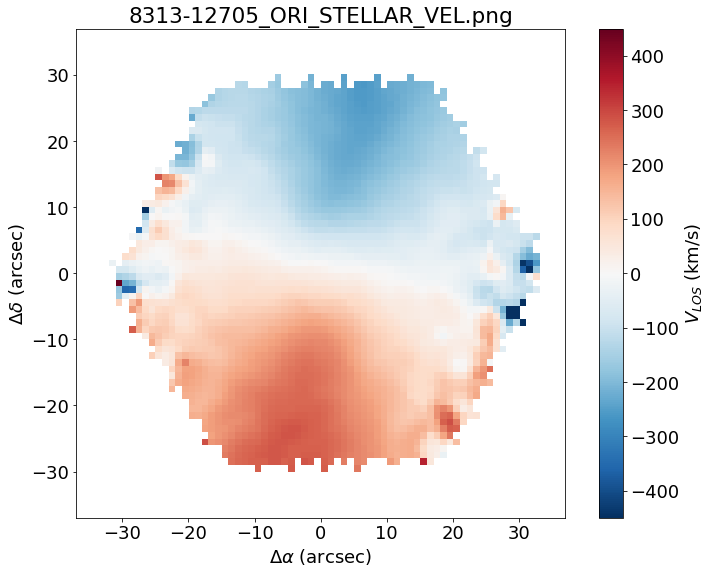

In [13]:
map_file='manga-'+plateifu+'-LOGCUBE_2DLOS.fits'
map_kind='STELLAR_VEL'
cmap=matplotlib.cm.RdBu_r
save_name=plateifu+'_ORI_'+map_kind+'.png'
crange=plot_2dmap(map_file, map_kind, crange=[], cmap=cmap, title=save_name,
                 save_plot=save_plot, save_name=save_name)

Save 2dmap plot into  8313-12705_DECONV_STELLAR_VEL.png


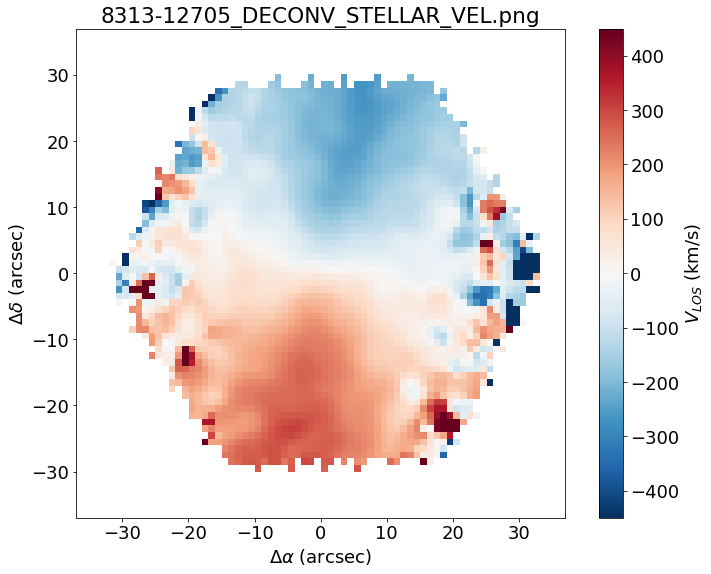

In [14]:
map_file='manga-'+plateifu+'-LOGDCCUBE_2DLOS.fits'
map_kind='STELLAR_VEL'
cmap=matplotlib.cm.RdBu_r
save_name=plateifu+'_DECONV_'+map_kind+'.png'
crange=plot_2dmap(map_file, map_kind, crange=crange, cmap=cmap, title=save_name,
                 save_plot=save_plot, save_name=save_name)

Save 2dmap plot into  8313-12705_ORI_STELLAR_SIGMA.png


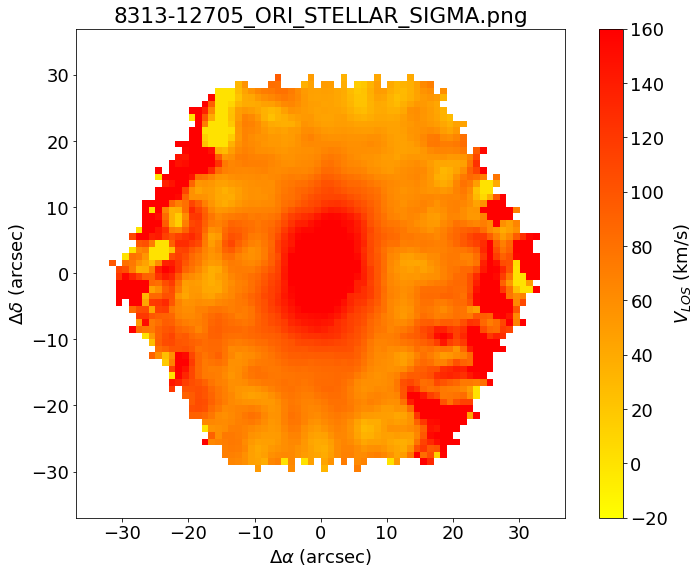

In [15]:
map_file='manga-'+plateifu+'-LOGCUBE_2DLOS.fits'
map_kind='STELLAR_SIGMA'
cmap=cm.autumn_r
save_name=plateifu+'_ORI_'+map_kind+'.png'
crange=plot_2dmap(map_file, map_kind, crange=[], cmap=cmap, title=save_name,
                 save_plot=save_plot, save_name=save_name)

Save 2dmap plot into  8313-12705_DECONV_STELLAR_SIGMA.png


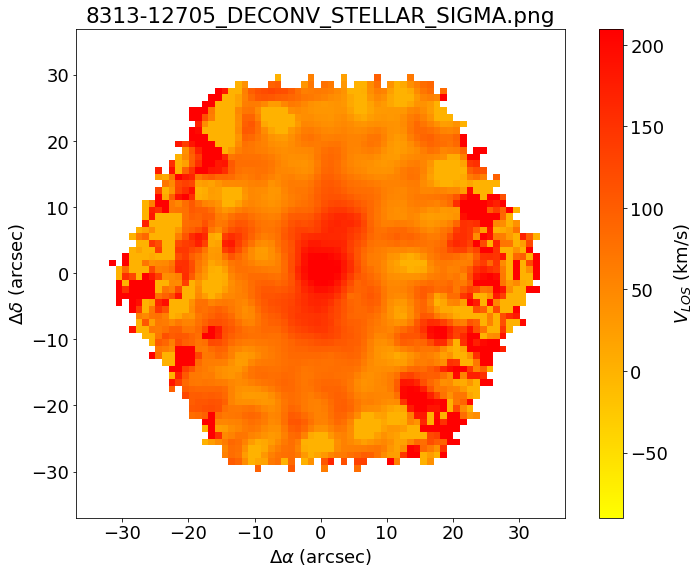

In [16]:
map_file='manga-'+plateifu+'-LOGDCCUBE_2DLOS.fits'
map_kind='STELLAR_SIGMA'
cmap=cm.autumn_r
save_name=plateifu+'_DECONV_'+map_kind+'.png'
crange=plot_2dmap(map_file, map_kind, crange=[], cmap=cmap, title=save_name,
                 save_plot=save_plot, save_name=save_name)